### Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics

In [3]:
import random
import feather

In [4]:
import lightgbm as lgb

### Constants and funcs 

In [5]:
PATH = 'data/house_prices/'

In [6]:
!ls {PATH}

data_description.txt   sample_submission.csv.gz  test.csv.gz  train.csv
sample_submission.csv  test.csv			 tmp	      train.csv.gz


In [7]:
# number ov cv splits
N_SPLITS=5

In [8]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [9]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [12]:
# Count the lines
num_lines = sum(1 for l in open(f'{PATH}train.csv'))

# Sample size - in this case ~10%
size = int(num_lines / 10)

# The row indices to skip - make sure 0 is not included to keep the header!
skip_idx = random.sample(range(1, num_lines), num_lines - size)

### Loads 

In [16]:
sample_df = pd.read_csv(f'{PATH}train.csv', skiprows=skip_idx)

In [9]:
raw_train_df = pd.read_csv(f'{PATH}train.csv', low_memory=False)

In [10]:
raw_test_df = pd.read_csv(f'{PATH}test.csv')

In [11]:
len(raw_train_df), len(raw_test_df)

(1460, 1459)

### EDA on sample

In [17]:
sample_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,27,20,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,134800
1,32,20,RL,NaN,8544,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2008,WD,Normal,149350
2,49,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
3,59,60,RL,66.0,13682,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,10,2006,New,Partial,438780
4,64,70,RM,50.0,10300,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,GdPrv,NaN,0,4,2010,WD,Normal,140000


In [21]:
display_all(sample_df.describe(include='all'))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,145.00000,145.000000,145,122.000000,145.000000,145,7,145,145,145,145,145,145,145,145,145,145,145.000000,145.000000,145.000000,145.000000,145,145,145,145,144,144.000000,145,145,145,142,142,142,142,145.000000,141,145.000000,145.000000,145.000000,145,145,145,145,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145,145.000000,145,145.000000,70,136,136.000000,136,145.000000,145.000000,136,136,145,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,1,33,3,145.000000,145.000000,145.000000,145,145,145.000000
unique,NaN,NaN,5,NaN,NaN,1,2,4,4,1,4,3,22,6,3,5,8,NaN,NaN,NaN,NaN,4,2,12,14,4,NaN,4,4,5,4,3,4,6,NaN,6,NaN,NaN,NaN,3,4,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,5,NaN,5,4,NaN,3,NaN,NaN,3,2,3,NaN,NaN,NaN,NaN,NaN,NaN,1,4,2,NaN,NaN,NaN,6,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Ex,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,110,NaN,NaN,145,6,96,127,145,103,135,21,128,142,121,80,NaN,NaN,NaN,NaN,111,144,40,39,86,NaN,96,132,65,67,131,89,50,NaN,125,NaN,NaN,NaN,143,69,138,132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78,NaN,137,NaN,37,84,NaN,71,NaN,NaN,130,131,131,NaN,NaN,NaN,NaN,NaN,NaN,1,16,2,NaN,NaN,NaN,121,113,NaN
mean,771.17931,53.586207,NaN,70.565574,10360.986207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.096552,5.648276,1969.275862,1984.317241,NaN,NaN,NaN,NaN,NaN,104.534722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,379.234483,NaN,60.717241,648.455172,1088.406897,NaN,NaN,NaN,NaN,1165.979310,315.551724,10.503448,1492.034483,0.413793,0.068966,1.565517,0.337931,2.868966,1.082759,NaN,6.496552,NaN,0.531034,NaN,NaN,1978.948529,NaN,1.820690,471.186207,NaN,NaN,NaN,90.620690,53.875862,23.848276,2.124138,10.227586,3.531034,NaN,NaN,NaN,8.275862,6.758621,2007.951724,NaN,NaN,179422.813793
std,418.68411,39.165352,NaN,23.422454,7412.202802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.415804,1.102592,30.977026,21.106444,NaN,NaN,NaN,NaN,NaN,175.014921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.885730,NaN,199.260323,512.833008,469.782596,NaN,NaN,NaN,NaN,396.174107,429.637605,58.767683,497.502811,0.508077,0.254274,0.575106,0.503056,0.801519,0.300542,NaN,1.704260,NaN,0.589906,NaN,NaN,24.623181,NaN,0.847127,230.406012,NaN,NaN,NaN,132.393514,90.185371,66.734167,18.098835,49.056479,42.519286,NaN,NaN,NaN,74.071520,2.677779,1.303473,NaN,NaN,84286.253844
min,27.00000,20.000000,NaN,21.000000,1680.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,3.000000,1893.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,483.000000,0.000000,0.000000,672.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,3.000000,NaN,0.000000,NaN,NaN,1914.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000

In [19]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 81 columns):
Id               145 non-null int64
MSSubClass       145 non-null int64
MSZoning         145 non-null object
LotFrontage      122 non-null float64
LotArea          145 non-null int64
Street           145 non-null object
Alley            7 non-null object
LotShape         145 non-null object
LandContour      145 non-null object
Utilities        145 non-null object
LotConfig        145 non-null object
LandSlope        145 non-null object
Neighborhood     145 non-null object
Condition1       145 non-null object
Condition2       145 non-null object
BldgType         145 non-null object
HouseStyle       145 non-null object
OverallQual      145 non-null int64
OverallCond      145 non-null int64
YearBuilt        145 non-null int64
YearRemodAdd     145 non-null int64
RoofStyle        145 non-null object
RoofMatl         145 non-null object
Exterior1st      145 non-null object
Exterior2nd    

###  Fast cleaning and preparation

In [26]:
# use `add_datepart` to add different datetime features (works with datetime columns)

In [12]:
# object dtype -> category
train_cats(raw_train_df)

In [13]:
# apply same categories as in train for test
apply_cats(raw_test_df, raw_train_df)

In [14]:
raw_train_df.MSZoning.cat.categories

Index(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype='object')

In [15]:
raw_test_df.MSZoning.cat.categories

Index(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype='object')

In [15]:
# percent of nans
display_all(raw_train_df.isnull().sum().sort_index()/len(raw_train_df))

1stFlrSF         0.000000
2ndFlrSF         0.000000
3SsnPorch        0.000000
Alley            0.937671
BedroomAbvGr     0.000000
BldgType         0.000000
BsmtCond         0.025342
BsmtExposure     0.026027
BsmtFinSF1       0.000000
BsmtFinSF2       0.000000
BsmtFinType1     0.025342
BsmtFinType2     0.026027
BsmtFullBath     0.000000
BsmtHalfBath     0.000000
BsmtQual         0.025342
BsmtUnfSF        0.000000
CentralAir       0.000000
Condition1       0.000000
Condition2       0.000000
Electrical       0.000685
EnclosedPorch    0.000000
ExterCond        0.000000
ExterQual        0.000000
Exterior1st      0.000000
Exterior2nd      0.000000
Fence            0.807534
FireplaceQu      0.472603
Fireplaces       0.000000
Foundation       0.000000
FullBath         0.000000
Functional       0.000000
GarageArea       0.000000
GarageCars       0.000000
GarageCond       0.055479
GarageFinish     0.055479
GarageQual       0.055479
GarageType       0.055479
GarageYrBlt      0.055479
GrLivArea   

In [16]:
raw_train_df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [17]:
# save to feather
os.makedirs(f'{PATH}tmp', exist_ok=True)

In [18]:
raw_train_df.to_feather(f'{PATH}tmp/train.ft')
raw_test_df.to_feather(f'{PATH}tmp/test.ft')

#### Using proc_df

In [70]:
# load feather
raw_train_df = feather.read_dataframe(f'{PATH}tmp/train.ft')
raw_test_df = feather.read_dataframe(f'{PATH}tmp/test.ft')

In [71]:
raw_train_df.SalePrice = np.log(raw_train_df.SalePrice)

###  Data Cleaning (only after EDA)

#### Categories Joining for overall Quality

In [114]:
raw_train_df.loc[raw_train_df.OverallQual.isin([1,2,3,4]), 'OverallQual'] = 4
raw_test_df.loc[raw_test_df.OverallQual.isin([1,2,3,4]), 'OverallQual'] = 4

In [117]:
raw_train_df.loc[raw_train_df.OverallQual.isin([8,9,10]), 'OverallQual'] = 8
raw_test_df.loc[raw_test_df.OverallQual.isin([8,9,10]), 'OverallQual'] = 8

In [118]:
raw_train_df.OverallQual.unique(), raw_test_df.OverallQual.unique()

(array([7, 6, 8, 5, 4]), array([5, 6, 8, 7, 4]))

In [26]:
??proc_df

In [119]:
# label encoding and fillna with median with `proc_df`
df, y, nas = proc_df(raw_train_df, 'SalePrice', skip_flds=['Id'])

##### Sanity check

In [120]:
raw_train_df.loc[[10,20,30]]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
10,11,20,RL,70.0,11200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,11.771436
20,21,60,RL,101.0,14215,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2006,New,Partial,12.692503
30,31,70,C (all),50.0,8500,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal,10.596635


In [121]:
df.loc[[10,20,30]]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
10,20,4,70.0,11200,2,0,4,4,1,5,...,0,0,0,2,2008,9,5,False,False,False
20,60,4,101.0,14215,2,0,1,4,1,1,...,0,0,0,11,2006,7,6,False,False,False
30,70,1,50.0,8500,2,2,4,4,1,5,...,3,0,0,7,2008,9,5,False,False,False


In [122]:
test, _, _ = proc_df(raw_test_df, skip_flds=['Id'], na_dict=nas)

In [123]:
raw_test_df.loc[[1,5,10]]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
10,1471,120,RH,26.0,5858,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal


In [124]:
test.loc[[1,5,10]]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
1,20,4,81.0,14267,2,0,1,4,1,1,...,0,1,12500,6,2010,9,5,False,False,False
5,60,4,75.0,10000,2,0,1,4,1,1,...,0,0,0,4,2010,9,5,False,False,False
10,120,3,26.0,5858,2,0,1,4,1,3,...,0,0,0,6,2010,9,5,False,False,False


In [125]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
m.fit(df, y)
m.score(df,y)

0.9738086921039277

### Make validation 

#### Manual random split

In [126]:
all_index = raw_train_df.index.values
n_trn = int(len(all_index) * 0.67)
np.random.shuffle(all_index)

tr_index = all_index[:n_trn]
val_index = all_index[n_trn:]

In [127]:
raw_train = raw_train_df.loc[tr_index].copy()
raw_valid = raw_train_df.loc[val_index].copy()

In [128]:
raw_train.shape, raw_valid.shape

((978, 81), (482, 81))

In [129]:
X_train = df.loc[tr_index].copy()
X_valid = df.loc[val_index].copy()

In [130]:
X_train.shape, X_valid.shape

((978, 82), (482, 82))

In [131]:
y_train = y[tr_index].copy()
y_valid = y[val_index].copy()

In [132]:
y_train.shape, y_valid.shape

((978,), (482,))

##### Sanity check 

In [133]:
raw_train_df.SalePrice.mean(), y.mean()

(12.024050901109383, 12.024050901109383)

In [134]:
raw_train.SalePrice.mean(), y_train.mean()

(12.0291303125974, 12.0291303125974)

In [137]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, max_features=0.5)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 318 ms, sys: 18.8 ms, total: 337 ms
Wall time: 237 ms
[0.05455516348501713, 0.1561054369695413, 0.9810843275195549, 0.8510206402654549]


#### Simple train test split

In [464]:
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    df, y, test_size=0.33, random_state=43)

In [465]:
X_train.shape, y_train.shape

((978, 82), (978,))

In [34]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, max_features=0.5)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 310 ms, sys: 24.1 ms, total: 334 ms
Wall time: 334 ms
[0.052057891879638024, 0.15205898031589285, 0.9830425824256479, 0.8535962708498802]


In [446]:
y_pred = m.predict(test)

In [447]:
y_pred = np.exp(y_pred)

In [448]:
y_pred.mean()

176119.01017144794

#### Cross Val Score

In [424]:
model_params = {'n_estimators':160, 'min_samples_leaf':1, 'max_features':0.5}

In [425]:
m = RandomForestRegressor(n_jobs=-1, **model_params)

In [138]:
lgb_params = {'n_estimators':200, 'learning_rate':0.05}

In [139]:
m = lgb.LGBMRegressor(**lgb_params)

In [140]:
scoring = {'log_rmse': metrics.make_scorer(rmse)}

In [143]:
scores = sklearn.model_selection.cross_validate(
    m, df, y, cv=N_SPLITS, scoring=scoring,
    return_train_score=True, return_estimator=True)

In [144]:
scores['train_log_rmse'].mean(), scores['train_log_rmse'].std()*2

(0.042196684369706104, 0.00330470835017322)

In [145]:
f"mean_rmse: {scores['test_log_rmse'].mean()}, std*2: {scores['test_log_rmse'].std()*2}"

'mean_rmse: 0.13264816835266416, std*2: 0.019594369301533687'

In [146]:
y_pred = np.zeros(len(test))
for est in scores['estimator']:
    y_pred += est.predict(test) / N_SPLITS

In [147]:
y_pred = np.exp(y_pred)

### EDA

#### Feature importance

In [29]:
??rf_feat_importance

In [89]:
fi = rf_feat_importance(m, X_train); fi[:10]

,cols,imp
16,OverallQual,0.368046
45,GrLivArea,0.134265
26,ExterQual,0.069230
18,YearBuilt,0.061529
37,TotalBsmtSF,0.040187
42,1stFlrSF,0.037841
61,GarageArea,0.034565
60,GarageCars,0.034332
3,LotArea,0.020919
33,BsmtFinSF1,0.019740


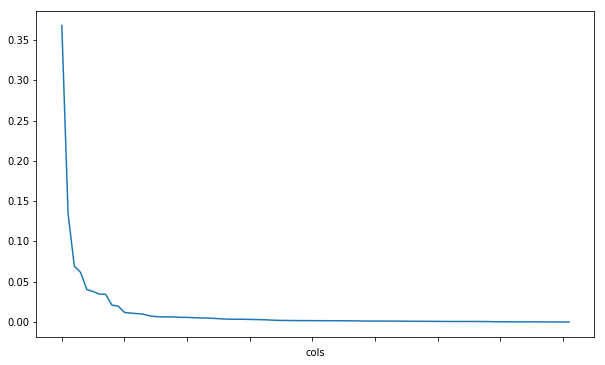

In [90]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [91]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

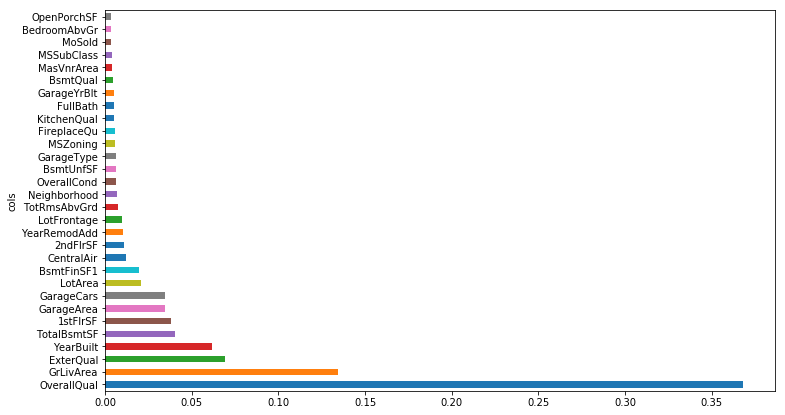

In [92]:
plot_fi(fi[:30]);

In [38]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

23

In [40]:
df_keep = df[to_keep].copy()

In [41]:
X_train = df_keep.loc[tr_index].copy()
X_valid = df_keep.loc[val_index].copy()

In [46]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, max_features=0.5)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 187 ms, sys: 25.3 ms, total: 212 ms
Wall time: 223 ms
[0.05470645511297044, 0.1381543744295399, 0.9813253711565894, 0.8789029512424646]


In [47]:
fi = rf_feat_importance(m, X_train); fi[:10]

,cols,imp
0,OverallQual,0.307370
1,GrLivArea,0.172605
2,YearBuilt,0.108954
3,ExterQual,0.051457
5,GarageArea,0.043535
4,GarageCars,0.039309
6,TotalBsmtSF,0.036921
8,1stFlrSF,0.034624
9,FullBath,0.032404
7,LotArea,0.025392


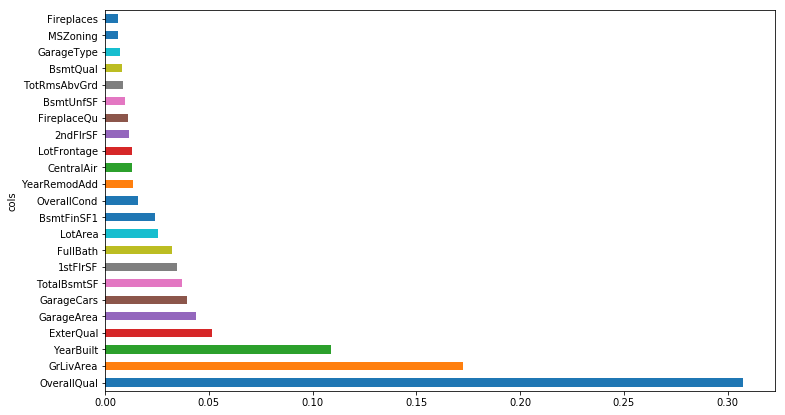

In [48]:
plot_fi(fi[:30]);

#### Confidence based on tree variance

In [93]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 50.6 ms, sys: 64.7 ms, total: 115 ms
Wall time: 243 ms


(11.67013547854385, 0.17634250797599593)

In [94]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)

In [95]:
categor_columns = [name for name in x.columns if (x[name].dtype.name == 'category' and 
                                                  len(x[name].cat.categories) < 5)]

In [96]:
categor_columns

['Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LandSlope',
 'MasVnrType',
 'ExterQual',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'CentralAir',
 'KitchenQual',
 'GarageFinish',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [101]:
fi[:10]

,cols,imp
16,OverallQual,0.368046
45,GrLivArea,0.134265
26,ExterQual,0.069230
18,YearBuilt,0.061529
37,TotalBsmtSF,0.040187
42,1stFlrSF,0.037841
61,GarageArea,0.034565
60,GarageCars,0.034332
3,LotArea,0.020919
33,BsmtFinSF1,0.019740


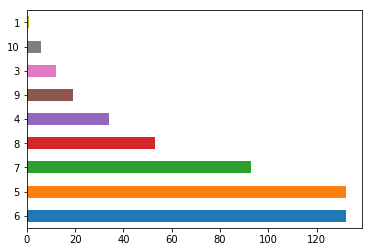

In [104]:
x.OverallQual.value_counts().plot.barh();

In [105]:
flds = ['OverallQual', 'SalePrice', 'pred', 'pred_std']
oq_summ = x[flds].groupby('OverallQual', as_index=False).mean()
oq_summ

,OverallQual,SalePrice,pred,pred_std
0,1,10.578980,11.077788,0.303880
1,3,11.328193,11.486650,0.256786
2,4,11.522133,11.560789,0.210706
3,5,11.785963,11.780443,0.160265
4,6,11.975851,11.960362,0.154756
5,7,12.243053,12.209764,0.151766
6,8,12.482461,12.479216,0.183727
7,9,12.808894,12.743870,0.201171
8,10,12.722609,12.854779,0.217313


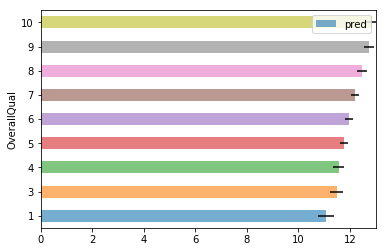

In [106]:
oq_summ = oq_summ[~pd.isnull(oq_summ.SalePrice)]
oq_summ.plot('OverallQual', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,13));

In [107]:
(oq_summ.pred_std/oq_summ.pred).sort_values(ascending=False)

0    0.027431
1    0.022355
2    0.018226
8    0.016905
7    0.015786
6    0.014723
3    0.013604
4    0.012939
5    0.012430
dtype: float64

*Probably should combine rare categories somehow*

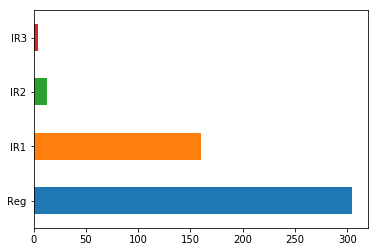

In [47]:
x.LotShape.value_counts().plot.barh();

In [48]:
flds = ['LotShape', 'SalePrice', 'pred', 'pred_std']
lotsh_summ = x[flds].groupby('LotShape', as_index=False).mean()
lotsh_summ

,LotShape,SalePrice,pred,pred_std
0,IR1,12.149377,12.133364,0.165150
1,IR2,12.169258,12.148942,0.144462
2,IR3,12.319963,12.606253,0.196500
3,Reg,11.911942,11.924530,0.170701


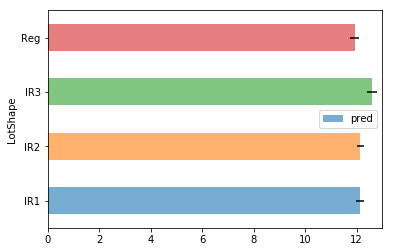

In [51]:
lotsh_summ = lotsh_summ[~pd.isnull(lotsh_summ.SalePrice)]
lotsh_summ.plot('LotShape', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,13));

### Submission 

In [148]:
submission = pd.read_csv(f'{PATH}sample_submission.csv')

In [149]:
submission.SalePrice.mean()

179183.91824266256

In [150]:
all(submission.Id == raw_test_df.Id)

True

In [151]:
submission.SalePrice = y_pred

In [152]:
submission.SalePrice.mean()

176819.19493992504

In [153]:
os.makedirs(f'{PATH}tmp/subm', exist_ok=True)

In [154]:
submission.to_csv(f'{PATH}tmp/subm/lgb_cv_ovqual_joined.csv', index=False, header=True)